In [2]:

!pip install tensorflow kaggle

from google.colab import files
files.upload()  # Upload your kaggle.json file

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# Unzip the dataset
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.82GB/s]


In [5]:
import os
import shutil
import random
from pathlib import Path

# Create validation directory structure
os.makedirs('validation/REAL', exist_ok=True)
os.makedirs('validation/FAKE', exist_ok=True)

# Set seed for reproducibility
random.seed(42)

# Move 10,000 REAL images from train to validation
real_train_path = 'train/REAL'
real_val_path = 'validation/REAL'
real_images = os.listdir(real_train_path)
random.shuffle(real_images)
images_to_move = real_images[:10000]

for img in images_to_move:
    src = os.path.join(real_train_path, img)
    dst = os.path.join(real_val_path, img)
    shutil.move(src, dst)

print(f"Moved {len(images_to_move)} REAL images to validation")

# Move 10,000 FAKE images from train to validation
fake_train_path = 'train/FAKE'
fake_val_path = 'validation/FAKE'
fake_images = os.listdir(fake_train_path)
random.shuffle(fake_images)
images_to_move = fake_images[:10000]

for img in images_to_move:
    src = os.path.join(fake_train_path, img)
    dst = os.path.join(fake_val_path, img)
    shutil.move(src, dst)

print(f"Moved {len(images_to_move)} FAKE images to validation")

# Verify the split
print(f"\nTrain REAL images: {len(os.listdir('train/REAL'))}")
print(f"Train FAKE images: {len(os.listdir('train/FAKE'))}")
print(f"Validation REAL images: {len(os.listdir('validation/REAL'))}")
print(f"Validation FAKE images: {len(os.listdir('validation/FAKE'))}")
print(f"Test REAL images: {len(os.listdir('test/REAL'))}")
print(f"Test FAKE images: {len(os.listdir('test/FAKE'))}")

Moved 10000 REAL images to validation
Moved 10000 FAKE images to validation

Train REAL images: 40000
Train FAKE images: 40000
Validation REAL images: 10000
Validation FAKE images: 10000
Test REAL images: 10000
Test FAKE images: 10000


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
# Load datasets using image_dataset_from_directory
img_height = 32
img_width = 32
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    'train',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    'test',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 80000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [3]:
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load datasets with HIGHER resolution (224x224 instead of 32x32)
img_height = 224
img_width = 224
batch_size = 32

# Enhanced data augmentation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def augment_data(image, label):
    image = data_augmentation(image, training=True)
    return image, label

train_ds = tf.keras.utils.image_dataset_from_directory(
    'train',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    'test',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

# Apply augmentation to training data
train_ds = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Normalize pixel values
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 80000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [5]:
def build_enhanced_model():
    """Enhanced model with more capacity and better regularization"""
    inputs = keras.Input(shape=(224, 224, 3))

    # First Block
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Second Block
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Third Block
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Fourth Block
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = build_enhanced_model()

# Display model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 5,090,369 (19.42 MB)

 Trainable params: 5,084,993 (19.40 MB)

 Non-trainable params: 5,376 (21.00 KB)

Found 80000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 847,905 (3.23 MB)

 Trainable params: 846,241 (3.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7786 - loss: 0.5075
Epoch 1: val_accuracy improved from -inf to 0.90070, saving model to best_model_improved.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - accuracy: 0.7786 - loss: 0.5075 - val_accuracy: 0.9007 - val_loss: 0.3295 - learning_rate: 0.0010
Epoch 2/50
1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8817 - loss: 0.3615
Epoch 2: val_accuracy improved from 0.90070 to 0.91740, saving model to best_model_improved.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8817 - loss: 0.3615 - val_accuracy: 0.9174 - val_loss: 0.3059 - learning_rate: 0.0010
Epoch 3/50
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8982 - loss: 0.3324
Epoch 3: val_accuracy did not improve from 0.91740
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8982 - loss: 0.3324 - val_accuracy: 0.9061 - val_loss: 0.3203 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

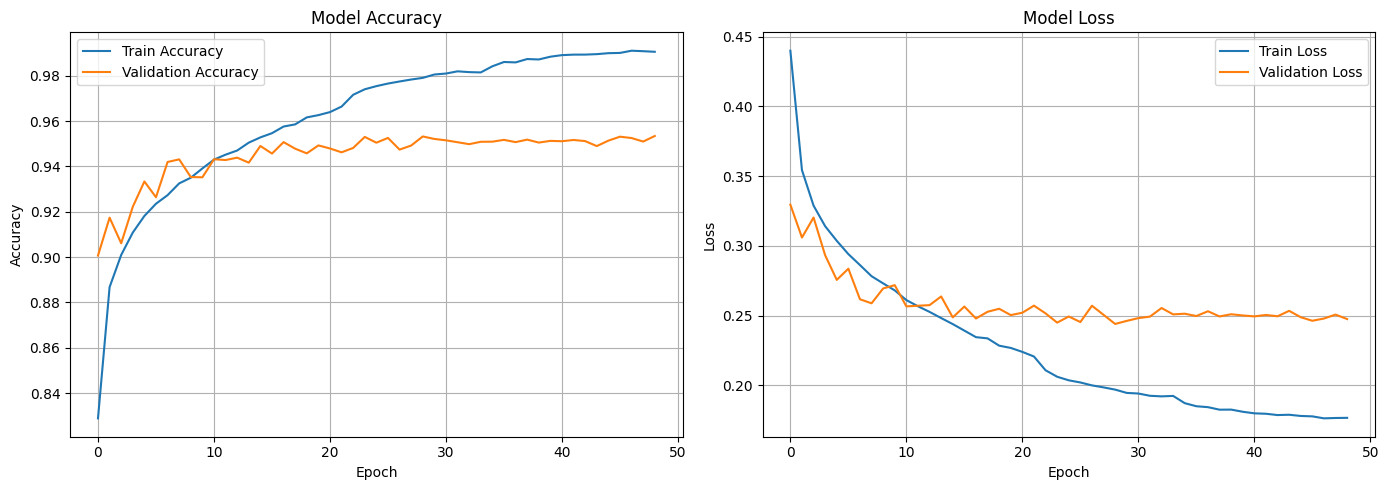


Best Validation Accuracy: 95.34%
Final Test Accuracy: 95.33%


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Image parameters
img_height = 32
img_width = 32
batch_size = 64

# Data Augmentation for training set (Slightly reduced aggression for better feature retention)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # Reduced from 0.15 to 0.1
    layers.RandomZoom(0.08),     # Reduced from 0.1 to 0.08
    layers.RandomContrast(0.2),
])

# Load datasets with proper preprocessing
# NOTE: Ensure 'train', 'validation', and 'test' directories exist with image data
train_ds = tf.keras.utils.image_dataset_from_directory(
    'train',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    'test',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

# Apply data augmentation only to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

def build_improved_cifake_model():
    initializer = 'lecun_normal'

    model = keras.Sequential([
        # Normalization layer
        layers.Rescaling(1./255, input_shape=(32, 32, 3)),
        layers.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229**2, 0.224**2, 0.225**2]),

        # First Conv Block
        layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Conv Block
        layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Conv Block
        layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(256, kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4), # Reduced from 0.5 to 0.4
        layers.Dense(128, kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4), # Reduced from 0.5 to 0.4
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create the model
model = build_improved_cifake_model()

# Display model architecture
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.07) 

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

# Enhanced callbacks (No changes, they are well-tuned)
callbacks = [
    # Save best model
    ModelCheckpoint(
        'best_model_improved.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
]

# Train the model
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Load the best model
best_model = keras.models.load_model('best_model_improved.keras')

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f'\nTest accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f'\nBest Validation Accuracy: {max(history.history["val_accuracy"]) * 100:.2f}%')
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')